In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
vcf = "../../../data/HG002/variants/ConSTRain/HG002.GRCh38.100x.ConSTRain_v0.7.0.vcf" # str: path to input vcf file                      
vcf_format = "ConSTRain" # str: which tool was used to genotype
sample = "HG002.GRCh38.2x250" # str: name of sample in vcf to analyse
set_cn = False # bool: set CN of loci manually (based on chromosome name)
gt_in_bp = False # bool: does the tool report genotypes in bp (True) or in number of repeat units (False)
strs_covered_by_haplotypes = "../../../data/HG002/regions/hg38_ver13_0boe_mononucleotides_union.bed" # str: path to bed with loci that are covered by the haplotypes provided by Q100
haplotype_str_length = "../../../data/HG002/variants/HG002_GRCh38_STR_lengths.csv" # str: path to csv with STR allele lengths based on Q100 haplotypes
comparison_file_out = None # None or str: path to write csv with comparison of STR allele lengths from vcf to Q100 STR allele lengths


In [4]:
def set_cn_manually(df):
    autosomes = [f"chr{i}" for i in range(1, 23)]
    df = df.assign(
        copy_number = lambda x: [2 if i in autosomes else 1 for i in x["chr"]]
    )
    return df

In [5]:
df_repeats, df_hg002 = file_io.dfs_from_vcf(filename=vcf, samples=[sample], vcf_format=vcf_format)
print(df_repeats.shape, df_hg002.shape)

df_covered_repeats = pd.read_csv(strs_covered_by_haplotypes, sep="\t", names=["chr", "start", "end", "period", "unit"])
df_covered_repeats = df_covered_repeats.assign(
            str_id = np.array([f"{chrom}_{start + 1}" for chrom, start in zip(df_covered_repeats.chr, df_covered_repeats.start)])
)

df_covered_repeats = df_repeats[df_repeats["str_id"].isin(df_covered_repeats["str_id"])]

df_hg002 = df_hg002.merge(
    df_covered_repeats[["str_id", "chr", "start", "end", "period", "unit", "ref"]], on="str_id", how="inner"
)

if set_cn:
    df_hg002 = set_cn_manually(df_hg002)
    
df_hg002 = df_hg002.dropna().reset_index(drop=True)

print(df_covered_repeats.shape, df_hg002.shape)

df_hg002


(1733646, 7) (1733646, 5)
(1695865, 7) (1671143, 11)


,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,CCT,4
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",chr1,589245,589256,2,TC,6
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",chr1,590659,590670,4,AAAT,3
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",chr1,590969,590984,4,AAAC,4
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",chr1,591734,591751,1,A,18
...,...,...,...,...,...,...,...,...,...,...,...
1671138,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],chrY,26628607,26628621,5,ATTTT,3
1671139,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],chrY,26632688,26632705,3,TTC,6
1671140,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],chrY,26635262,26635271,1,A,10
1671141,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],chrY,26637436,26637447,3,TTA,4


In [6]:
if gt_in_bp:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted(gt) for gt in x["genotype"]],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
else:
    df_hg002 = df_hg002.assign(
        illumina_region_len = lambda x: [sorted([k * j for k in i]) for i, j in zip(x["genotype"], x["period"])],
        depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    )
    
df_hg002

,sample,str_id,copy_number,frequencies,genotype,chr,start,end,period,unit,ref,illumina_region_len,depth
0,HG002.GRCh38.2x250,chr1_588068,2,{4: 22},"[4, 4]",chr1,588068,588079,3,CCT,4,"[12, 12]",22
1,HG002.GRCh38.2x250,chr1_589245,2,{6: 9},"[6, 6]",chr1,589245,589256,2,TC,6,"[12, 12]",9
2,HG002.GRCh38.2x250,chr1_590659,2,{3: 60},"[3, 3]",chr1,590659,590670,4,AAAT,3,"[12, 12]",60
3,HG002.GRCh38.2x250,chr1_590969,2,{4: 42},"[4, 4]",chr1,590969,590984,4,AAAC,4,"[16, 16]",42
4,HG002.GRCh38.2x250,chr1_591734,2,"{18: 2, 20: 9}","[20, 20]",chr1,591734,591751,1,A,18,"[20, 20]",11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1671138,HG002.GRCh38.2x250,chrY_26628607,1,{3: 31},[3],chrY,26628607,26628621,5,ATTTT,3,[15],31
1671139,HG002.GRCh38.2x250,chrY_26632688,1,{6: 9},[6],chrY,26632688,26632705,3,TTC,6,[18],9
1671140,HG002.GRCh38.2x250,chrY_26635262,1,{10: 33},[10],chrY,26635262,26635271,1,A,10,[10],33
1671141,HG002.GRCh38.2x250,chrY_26637436,1,{4: 33},[4],chrY,26637436,26637447,3,TTA,4,[12],33


In [7]:
df_strs_haplotypes = pd.read_csv(haplotype_str_length).assign(chr = lambda x: [i[0] for i in x["str_id"].str.split("_")])
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr
0,chr1_588068,12,12.0,12.0,chr1
1,chr1_589245,12,12.0,12.0,chr1
2,chr1_590659,12,12.0,12.0,chr1
3,chr1_590969,16,16.0,16.0,chr1
4,chr1_591734,18,20.0,20.0,chr1
...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY
1695861,chrY_57200838,14,NaN,15.0,chrY
1695862,chrY_57201000,20,NaN,20.0,chrY
1695863,chrY_57202381,23,NaN,23.0,chrY


In [8]:
autosomes = "chr != 'chrX' and chr != 'chrY'"
X = "chr == 'chrX'"
Y = "chr == 'chrY'"

df_strs_haplotypes["haplo_region_len"] = [[] for i in range(len(df_strs_haplotypes))]

df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "haplo_region_len"] = pd.Series([
    sorted([np.int64(i), np.int64(j)]) for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_mat"], 
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(autosomes), "region_len_pat"],)])

for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(X), "region_len_mat"]):
    i.append(np.int64(j))
    
for i, j in zip(
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "haplo_region_len"],
        df_strs_haplotypes.loc[df_strs_haplotypes.eval(Y), "region_len_pat"]):
    i.append(np.int64(j))
    
df_strs_haplotypes

,str_id,region_len_ref,region_len_mat,region_len_pat,chr,haplo_region_len
0,chr1_588068,12,12.0,12.0,chr1,"[12, 12]"
1,chr1_589245,12,12.0,12.0,chr1,"[12, 12]"
2,chr1_590659,12,12.0,12.0,chr1,"[12, 12]"
3,chr1_590969,16,16.0,16.0,chr1,"[16, 16]"
4,chr1_591734,18,20.0,20.0,chr1,"[20, 20]"
...,...,...,...,...,...,...
1695860,chrY_57188868,11,NaN,11.0,chrY,[11]
1695861,chrY_57200838,14,NaN,15.0,chrY,[15]
1695862,chrY_57201000,20,NaN,20.0,chrY,[20]
1695863,chrY_57202381,23,NaN,23.0,chrY,[23]


In [9]:
df_comparison = (
    df_strs_haplotypes[["str_id", "haplo_region_len"]]
        .merge(df_hg002[["str_id", "illumina_region_len", "depth", "copy_number", "period"]], on="str_id", how="inner")
        .assign(
            match = lambda x: x["haplo_region_len"] == x["illumina_region_len"],
        )
)

df_comparison

,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
0,chr1_588068,"[12, 12]","[12, 12]",22,2,3,True
1,chr1_589245,"[12, 12]","[12, 12]",9,2,2,True
2,chr1_590659,"[12, 12]","[12, 12]",60,2,4,True
3,chr1_590969,"[16, 16]","[16, 16]",42,2,4,True
4,chr1_591734,"[20, 20]","[20, 20]",11,2,1,True
...,...,...,...,...,...,...,...
1671138,chrY_26628607,[15],[15],31,1,5,True
1671139,chrY_26632688,[19],[18],9,1,3,False
1671140,chrY_26635262,[10],[10],33,1,1,True
1671141,chrY_26637436,[12],[12],33,1,3,True


In [10]:
if comparison_file_out:
    df_comparison.to_csv(comparison_file_out, index=False)

In [11]:
n_wrong = df_comparison.loc[~df_comparison["match"]].shape[0]
n_total = df_comparison.shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

df_comparison.loc[~df_comparison["match"]]

n correct: 1581056, n wrong: 90087, n total: 1671143
Overall accuracy: 94.6092584536452


,str_id,haplo_region_len,illumina_region_len,depth,copy_number,period,match
31,chr1_647491,"[18, 18]","[18, 19]",25,2,1,False
36,chr1_651961,"[16, 16]","[17, 17]",9,2,1,False
52,chr1_720655,"[15, 15]","[16, 16]",55,2,1,False
53,chr1_725052,"[29, 30]","[29, 29]",1,2,1,False
61,chr1_739603,"[10, 10]","[10, 11]",75,2,1,False
...,...,...,...,...,...,...,...
1670901,chrY_26292042,[33],[31],2,1,1,False
1670903,chrY_26308422,[17],[16],1,1,1,False
1670919,chrY_26331846,[15],[18],14,1,1,False
1671139,chrY_26632688,[19],[18],9,1,3,False


In [32]:
min_depth = 15
max_depth = 85
query = f"depth / copy_number >= {min_depth} and depth / copy_number <= {max_depth}"

n_wrong = df_comparison.query(query).loc[~df_comparison.query(query)["match"]].shape[0]
n_total = df_comparison.query(query).shape[0]

print(f"n correct: {n_total - n_wrong}, n wrong: {n_wrong}, n total: {n_total}")
print("Overall accuracy:", (1 - (n_wrong / n_total)) * 100)

n correct: 1394429, n wrong: 18848, n total: 1413277
Overall accuracy: 98.66636193753949


In [12]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_comparison
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_comparison_filt = df_comparison.loc[df_comparison["str_id"].isin(selected_loci)]
    n.append(df_comparison_filt.shape[0])
    accuracy.append((1 - (df_comparison_filt.loc[~df_comparison_filt["match"]].shape[0] / df_comparison_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["accuracy"] = accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

In [13]:
for name, data in df_plot.groupby("depth"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())
print()
for name, data in df_plot.groupby("period"):
    print(name, np.average(data["accuracy"], weights=data["n"]), data["n"].sum())



1-5 54.28653712068391 65974
10-15 85.69648615822759 95508
15-20 92.88268925972334 120509
20-25 97.62813095304266 197903
25-30 99.19568576182553 336560
30- 99.62689036140185 740533
5-10 75.45450377129231 87238

1.0 92.0399677250228 856391
2.0 93.94078820783523 119537
3.0 98.4911093513786 138910
4.0 98.95153920118122 335921
5.0 98.39498479956193 158877
6.0 98.8609095377143 34589


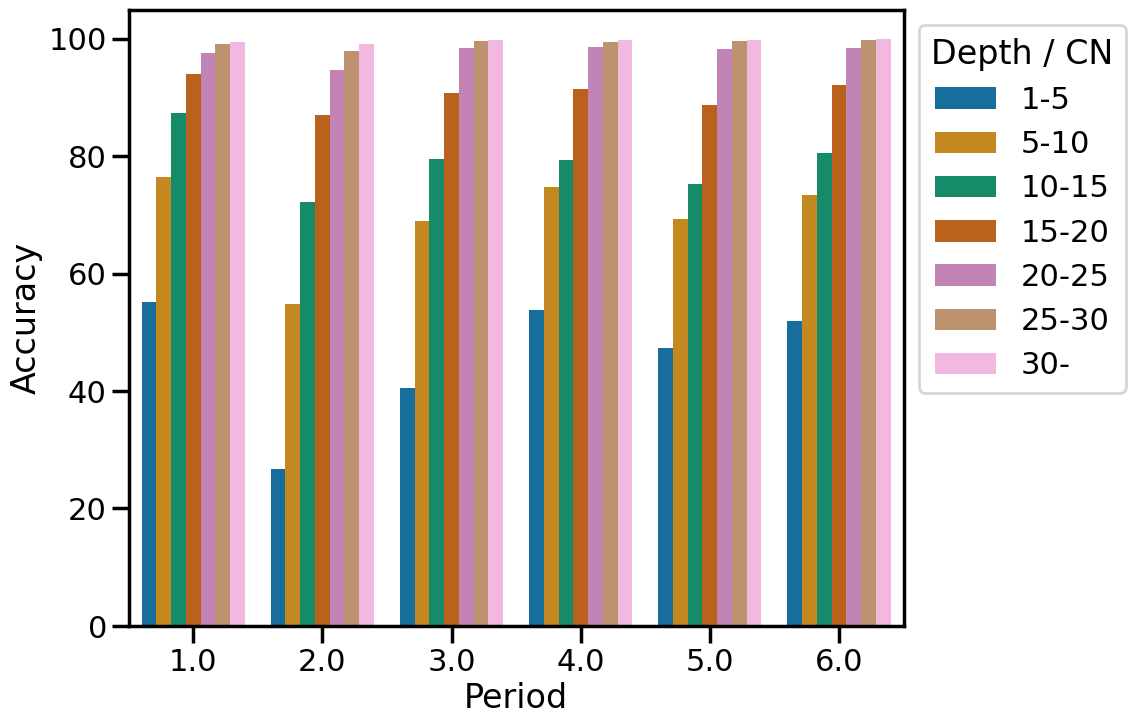

In [14]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    df_plot,
    x="period",
    y="accuracy",
    hue="depth",
    palette="colorblind"
)

ax.set(
    xlabel="Period",
    ylabel = "Accuracy"
)

_ = ax.get_legend().set(
    title="Depth / CN",
    bbox_to_anchor = (1, 1)
)

In [15]:
from scipy import ndimage

df_plot_density = (
    df_comparison
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["match", "period", "depth"]]
)

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .groupby(["depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
smooth = ndimage.gaussian_filter1d(df_plot_smooth["accuracy"], 3, mode="reflect")
df_plot_smooth = df_plot_smooth.assign(smooth = smooth)


df_plot_smooth_period = (
    df_plot_density
        .groupby(["period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
        # .query(f"n_obs >= {min_obs}")
        
)

smooth = []
for group, data in df_plot_smooth_period.groupby(["period"]):
    current_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(current_smooth)
df_plot_smooth_period = df_plot_smooth_period.assign(smooth = np.concatenate(smooth))

df_plot_smooth_period

,period,depth,accuracy,n_obs,smooth
0,1,0.5,0.273813,6614,0.420862
1,1,1.0,0.398346,7737,0.434360
2,1,1.5,0.417708,7522,0.459143
3,1,2.0,0.546705,5963,0.491544
4,1,2.5,0.503977,7921,0.527557
...,...,...,...,...,...
1138,6,126.0,1.000000,1,1.000000
1139,6,140.0,1.000000,1,1.000000
1140,6,147.0,1.000000,1,1.000000
1141,6,160.5,1.000000,1,1.000000


In [22]:
print(df_plot_smooth["n_obs"].sum())
print(df_plot_smooth.query("depth < 15")["n_obs"].sum())

1651663
256158


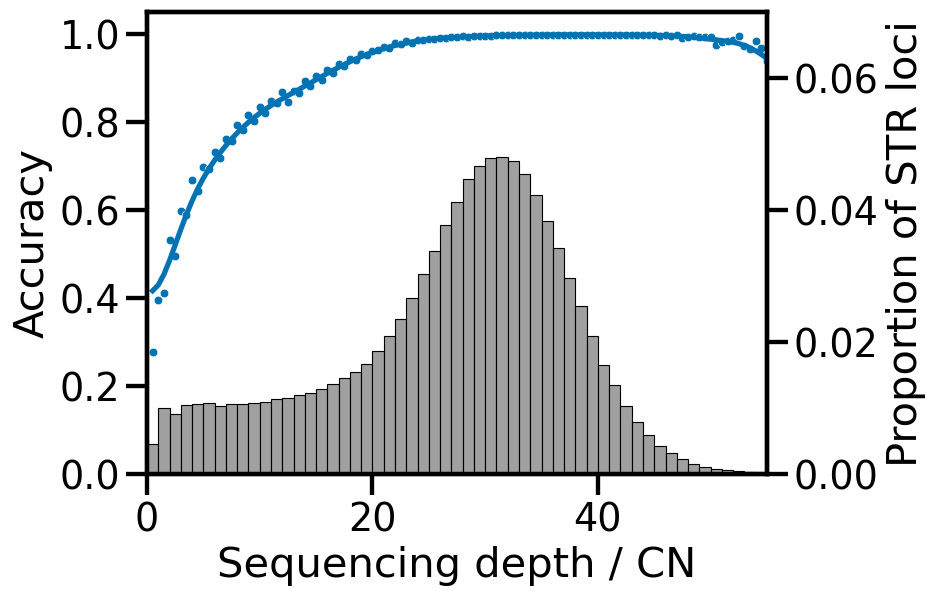

In [16]:
fig = plt.figure(dpi=125)

ax = sns.lineplot(
    df_plot_smooth,
    x = "depth",
    y = "smooth",
    color=sns.color_palette("colorblind")[0],
    # linewidth=2,
    legend=False
)

ax = sns.scatterplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    color=sns.color_palette("colorblind")[0],
    s=25,
    ax = ax,
    legend=False
)

ax.set(
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)

plt.show()

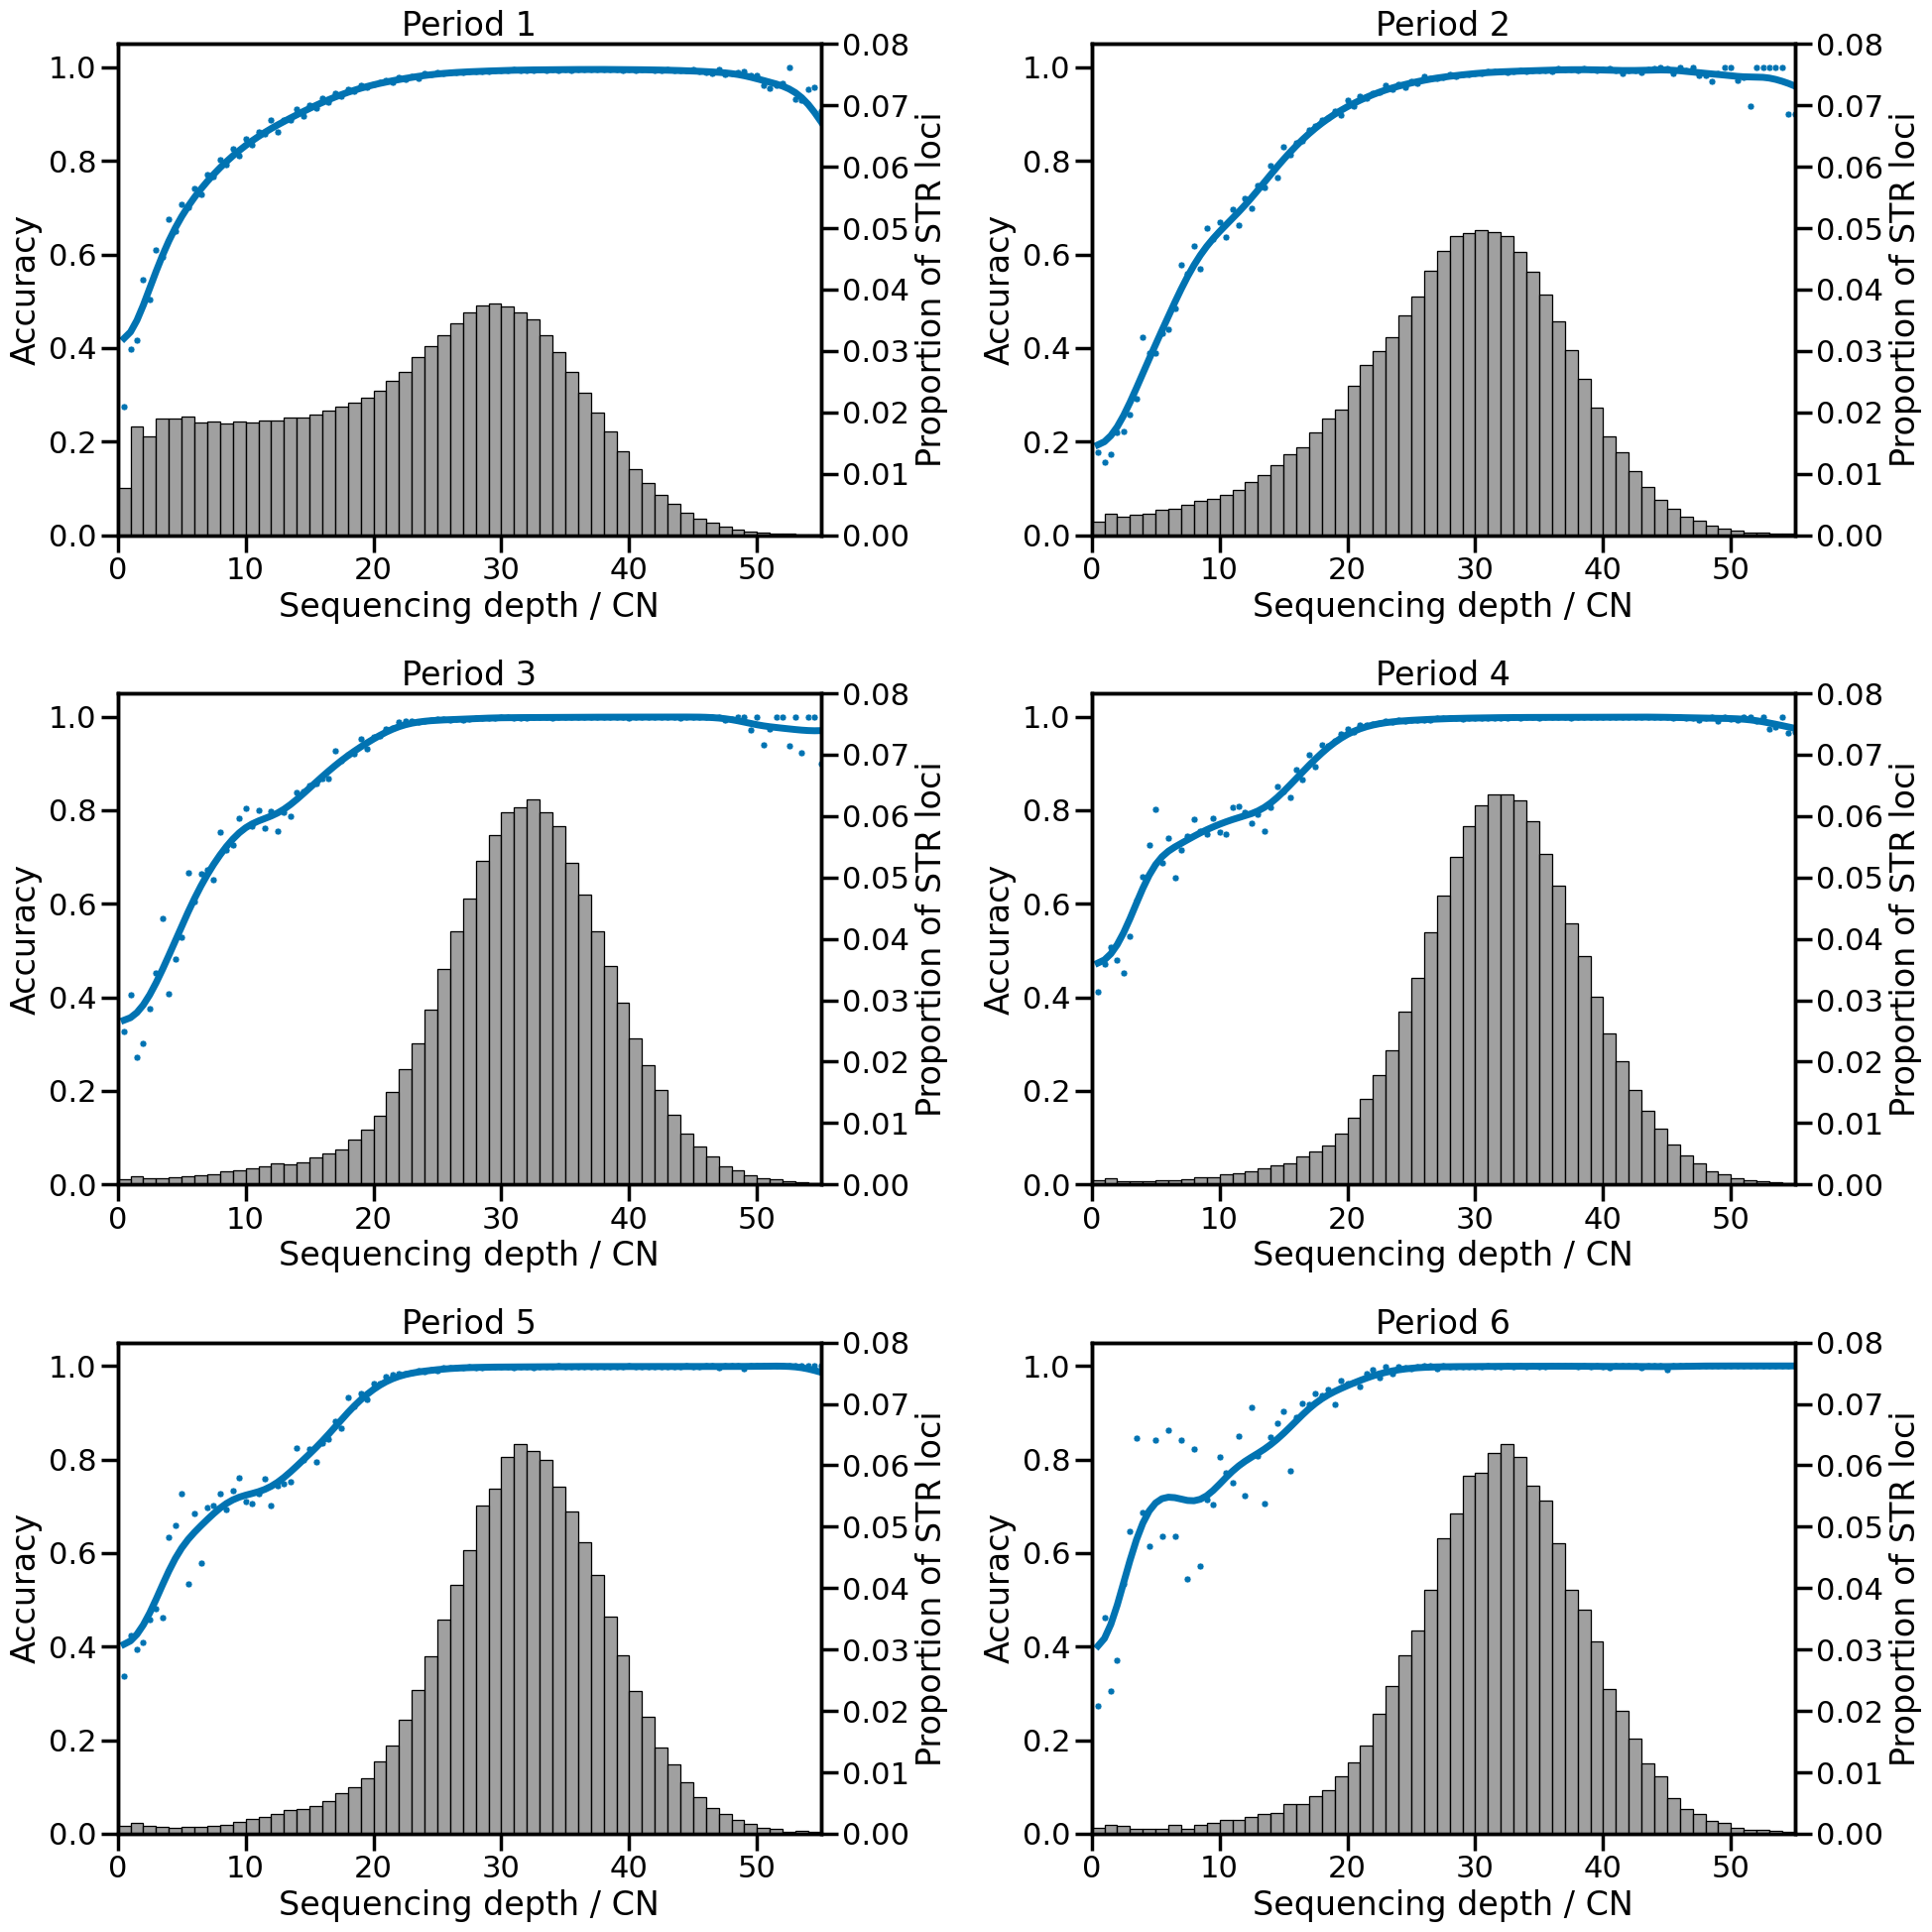

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.08),
    )

plt.tight_layout()

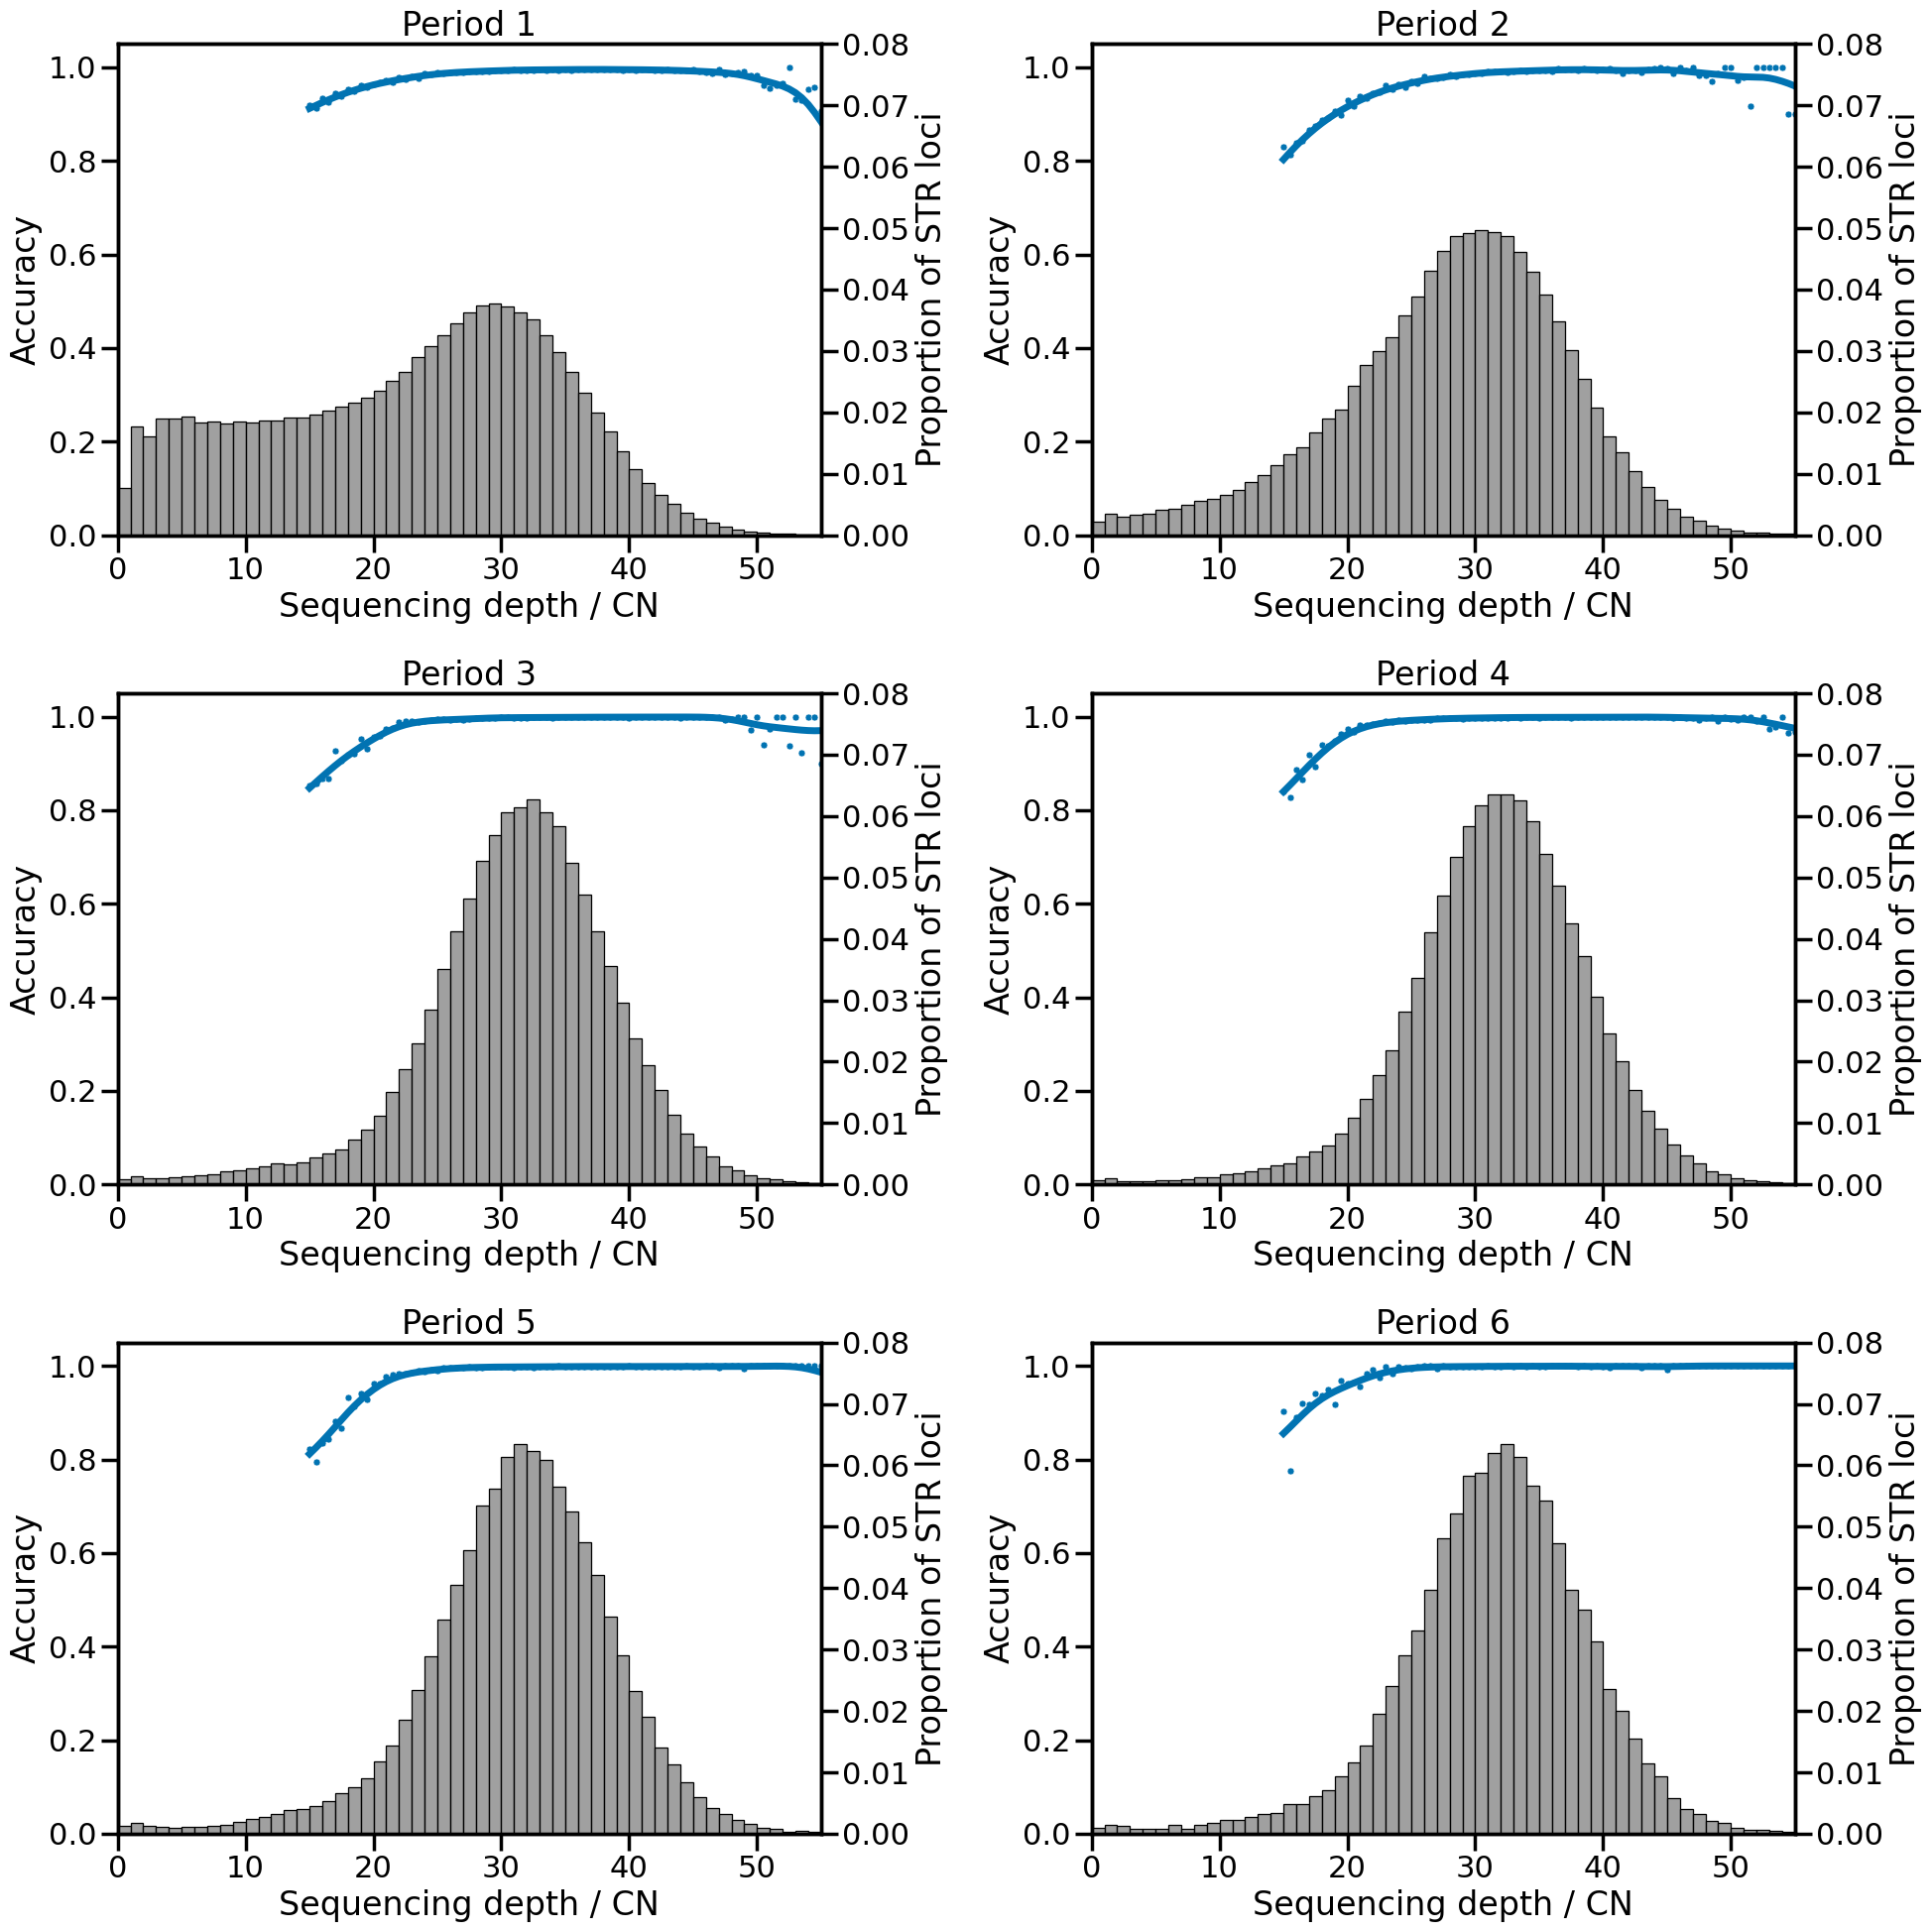

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period} and depth >= 15"))

    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "smooth",
        color=sns.color_palette("colorblind")[0],
        linewidth=5,
        ax = ax,
    )

    ax = sns.scatterplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        color=sns.color_palette("colorblind")[0],
        s=25,
        ax = ax,
    )

    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        ylim=(0, 0.08),
    )

plt.tight_layout()